## Анализ датасета, определение переменных для построения предсказывающей модели
Задан датасет с условиями жизни учащихся и их результатами по экзамену. Определить те условия, которые влияют на эти результаты. В дальнейшем выбранные условия должны использоваться для построения модели предсказывающей успеваемость учащихся.

### 1)    Загрузка модулей для анализа датасета
Также загружается словарь с названиями параметров и и возможными значениями. Словарь получен на основе анализа датасета по определению уникальных параметров.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind, norm
# dict_cat - словарь, key - название парметра из датасета, value - список значений параметра
import dict_cat

### 2) Загрузка датасета и определение функций для его обработки 
Функции для работы с датасетом

In [2]:
def check_category(line, dict_cat, str_category):
    """
        Проверка номинативных данных на соответствие заданным в словаре dc
    """
    if dict_cat[str_category][0] != 'numerical':
        if line in dict_cat[str_category]:
            return line
        else:
            return None
    else:
        return line


def calc_quantile(series_num):
    """
        Расчитать квантили для заданной числовой серии
    """
    # [series_num.notna()] - похоже не надо (тот же результат)
    q2 = series_num[series_num.notna()].median()
    q1 = series_num.quantile(0.25, interpolation='midpoint')
    q3 = series_num.quantile(0.75, interpolation='midpoint')
    iqr = q3 - q1
    return {'whisker1': q1 - 1.5*iqr, 'whisker2': q3 + 1.5*iqr,
            'Q1': q1, 'median': q2, 'Q3': q3, 'IQR': iqr}

Загрузка датасета

In [3]:
# словарь с допустимыми значениями номинативных переменных
dc = dict_cat.dict_cat

# название колонок
name_columns = list(dc.keys())

# загрузка датасета
stud = pd.read_csv('stud_math.csv')
stud.columns = name_columns

# тип данных в колонке
tp_stud = stud.dtypes

stud.info()
print('Пропущенные значения:\n', stud.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        392 non-null    float64
 7   Fedu        371 non-null    float64
 8   Mjob        376 non-null    object 
 9   Fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  schoolsup   386 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

Проверка номинативных переменных на соответствие заданным в описании

In [4]:
# очистка датасета (оставляем только заданные значения ном. переменных)
for name_col in name_columns:
    stud[name_col] = stud[name_col].apply(
        lambda x: check_category(x, dc, name_col))

### 3) Проверка числовых переменных, устранение выбросов.
#### 3.1 Анализ данных 'absences'

Для "absences"
 границы выбросов: [-12.0, 20.0]



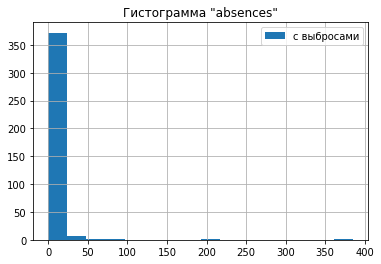

In [5]:
# гистограмма 'absences' с выбросами
plt.figure(1)
plt.clf()
plt.title('Гистограмма "absences"')
stud.absences.hist(bins=16, label='с выбросами')
plt.legend()

quant_absences = calc_quantile(stud.absences)
print('Для "absences"\n',
      "границы выбросов: [{f}, {l}]\n".format(f=quant_absences['whisker1'], l=quant_absences['whisker2']))

По квантилям границы выбросов [-12, 20], что сомнительно.
По распределению количества пропущенных занятий видно, что есть непрерывные значения от 0
до 30, далее отрыв до 38 и с этого значения идут числа с одним попаданием в датасете.
По "здравому смыслу" будем считать, что значение пропущеных занятий от 0 до 30. 

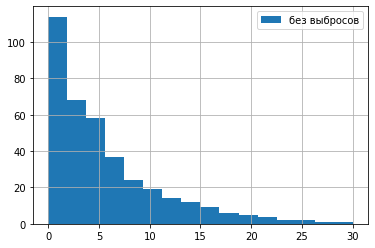

In [6]:
wh_high = 30  # почти непрерывное распределение до 30, дальше отрыв до 38
wh_low = 0    # >=0

# убрать выбросы из датасета
stud.absences = stud.absences.apply(lambda x: None if x > wh_high else x)
# Все None исключим при вычислении корреляции

# гистограмма без выбросов
plt.figure(2)
plt.clf()
stud.absences.hist(bins=16, label='без выбросов')
plt.legend()

#### 3.2 Анализ данных 'score'   

Для "score"
 границы выбросов: [-5.0, 115.0]



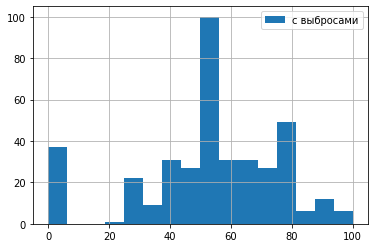

In [7]:
# убрать строки где 'score' = 'nan' поскольку нет целевого параметра
stud.drop(stud.index[stud['score'].isna()], inplace=True)

quant_score = calc_quantile(stud.score)
print('Для "score"\n',
      'границы выбросов: [{f}, {l}]\n'.format(f=quant_score['whisker1'], l=quant_score['whisker2']))

plt.figure(3)
plt.clf()
stud.score.hist(bins=16, label='с выбросами')
plt.legend()

По гистограмме видно, что есть разрыв между оценками 0 баллов и 20.
То есть меньше 20 скорее всего оценки не ставят. Оценка "0" может говорить
о каком-то событии, например, отсутствии экзамена.

Отсутствие экзамена и успеваемость могут иметь разные причины,
поэтому следует их исследовать раздельно. Проверка будет проведена по зависимости
выставленной оценки от влияющих факторов и по зависимости номинативного признака 
"присутствие" или "отсутствие(0)" экзамена.

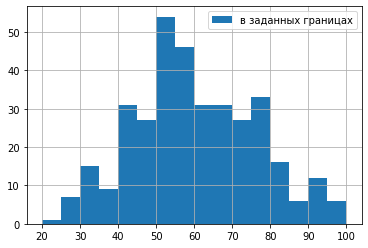

In [8]:
wh_high = 100  # максимальная оценка 100
wh_low = 1     # >=1
# устранять 0 не будем, но 0 балов или >0 обрабатывается отдельно

# график без выбросов
plt.figure(4)
plt.clf()
stud.score.loc[stud.score.between(wh_low, wh_high)].hist(
    bins=16, label='в заданных границах')
plt.legend()

#### 3.3 Анализ данных 'age'

Для "age" границы выбросов: [13.0, 21.0].


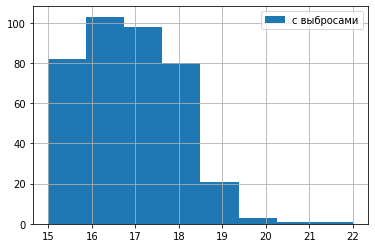

In [9]:
quant_age = calc_quantile(stud.age)
print('Для "age"',
      'границы выбросов: [{f}, {l}].'.format(f=quant_age['whisker1'], l=quant_age['whisker2']))

# гистограмма 'absences' с выбросами
plt.figure(5)
plt.clf()
stud.age.hist(bins=8, label='с выбросами')
plt.legend()

За границы попадает 22 в количестве 1, по смыслу это не выброс, а длинный
"хвост", выборку возраста оставляем как есть.
из info() видно, что "None" строк нет, удалять не надо

В столбцах с номинативными переменными убирать строки с "None" не будем поскольку в строках могут 
иметь значимые поля другие столбцы, строки с "None" исключим при обработке по признакам.

### 4) Корреляционный анализ  числовых переменных, проверка влияния параметра на 'score'.
Проверка связи между параметрами выраженных числами.
    
#### 4.1 Найдём переменные с корреляцией больше 0.25, для нахождения колонок со связанной информацией

In [10]:
st_corr = stud.corr()
for name_col, col_val in st_corr.items():
    for val in col_val.index:
        koef_corr = np.abs(st_corr[name_col][val])
        if (koef_corr > 0.25) & (name_col != val):
            print(name_col, val, koef_corr)

Medu Fedu 0.6265355114611304
Fedu Medu 0.6265355114611304
Fedu failures 0.2723523774900953
studytime granular 1.0000000000000016
failures Fedu 0.2723523774900953
failures score 0.3443382999897409
granular studytime 1.0000000000000016
freetime goout 0.29633812722743724
goout freetime 0.29633812722743724
score failures 0.3443382999897409


Высокая корреляция между образованием отца и матери, а также между свободным временем и временем с друзьями (что по житейской логике понятно), видно, что "studytime" и "granular" полностью коррелированы, удалим "granular". Параметры коррелированные с 'score' будут обрабатываться дальше.

Определять корреляцию между номинативными переменными неверно, но в данном случае получилось определить связь между "studytime" и "granular", поскольку они выражены числами, которые имеют линейную связь. Если бы они были обозначены произвольными символами, пришлось бы применять более сложный метод (не знаю). Не коррелированные переменные оставляем и будем опреледять их влияние на 'score' по отдельности.

In [11]:
try:
    stud.drop('granular', axis=1, inplace=True)
    name_columns.remove('granular')
except:
    print('already dropped')

#### 4.2 Определим коэффициент корреляции между числовыми параметрами.
    Сначала с 0 в 'score', потом без '0' для проверки предположения, что '0' - не числовая оценка


Корреляция с наличием "0" в "score"
               age  absences     score
age       1.000000  0.155755 -0.147750
absences  0.155755  1.000000  0.068886
score    -0.147750  0.068886  1.000000


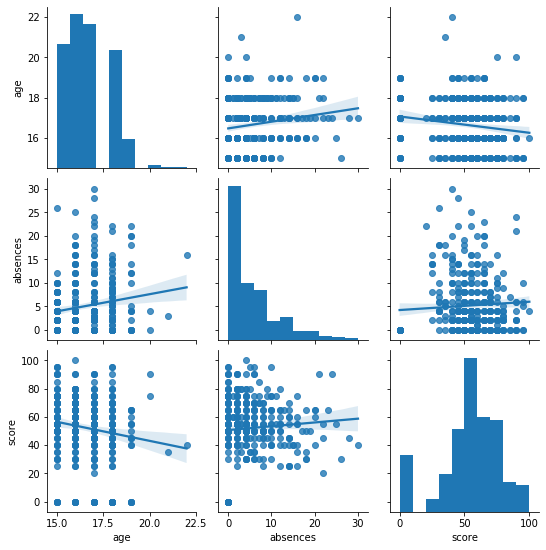

In [12]:
# корреляция между числовыми переменными 'age', 'absences', 'score' (с 0 в 'score')
# убрать None из 'absences'
stud2 = stud.drop(stud.index[stud['absences'].isna()], inplace=False)

sns.pairplot(stud2[['age', 'absences', 'score']], kind='reg')
st_corr_num = stud2.loc[:, ['age', 'absences', 'score']].corr()
print('\nКорреляция с наличием "0" в "score"')
print(st_corr_num)

Коэффициент корреляции:

между 'scrore' и 'age' -0.147750 (наверное есть влияние)

между 'scrore' и 'absences' 0.0688861

Корреляции между 'absences' и 'score' почти нет, что странно. По логике пропущенные занятия должны влиять на успеваемость.
Посмотрим без "0" в 'score'.


Корреляция без 0 в "score"
               age  absences     score
age       1.000000  0.204141 -0.118117
absences  0.204141  1.000000 -0.226403
score    -0.118117 -0.226403  1.000000


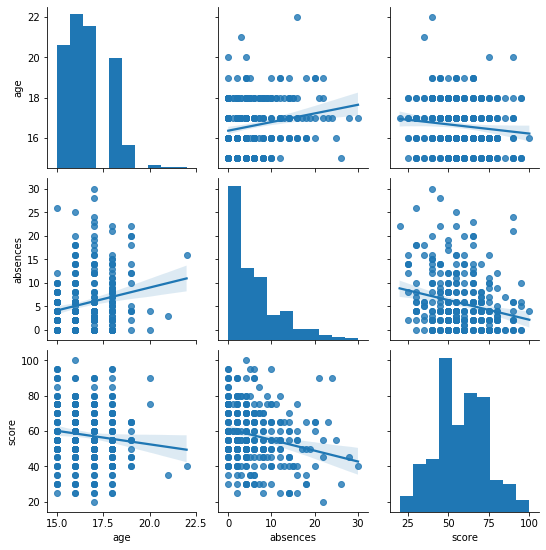

In [13]:
# убрать 0 из 'score'
stud2.drop(stud2.index[stud2['score'] == 0], inplace=True)
sns.pairplot(stud2[['age', 'absences', 'score']], kind='reg')
st_corr_num = stud2.loc[:, ['age', 'absences', 'score']].corr()
print('\nКорреляция без 0 в "score"')
print(st_corr_num)

Между 'scrore' и 'absences' -0.226403, что имеет смысл, чем больше пропусков, тем ниже бал экзамена. Что подтверждает исключения "0" в 'scrore' из анализа числовых данных и перевод его в номинативные.

### 5) Анализ номенативных переменных и определение влияющих на предсказываемую величину
#### 5.1 Функции используемые для анализа номинативных переменных.

In [14]:
def get_boxplot(column):
    """     
        column : название номинотивного параметра (колонки)
        Построение графика boxplot 'score' для значений 
        номинативных параметров из заданной колонки 
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score', data=stud[stud.score > 0], ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column, l_min=30):
    """
        Определение статистической значимости переменной в колонке "column"
        "l_min" - размер выборки пригодный для статистического анализа
    """    
    # комбинаций с None нет
    combinations_all = list(combinations(dc[column], 2))
    for comb in combinations_all:
        data1 = stud.loc[stud.loc[:, column] == comb[0], 'score']
        data2 = stud.loc[stud.loc[:, column] == comb[1], 'score']

        # считаем значимость без оценки "0"
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        l_data1 = len(data1)
        l_data2 = len(data2)

        # для выборок достаточного размера
        if (l_data1 >= l_min) and (l_data2 >= l_min):
            pv_test = ttest_ind(data1, data2).pvalue            
            if pv_test <= 0.05/len(combinations_all):  # Учли поправку Бонферони
                #                print('Найдены: ', column, ' pval={:.6f}'.format(pv_test), 'Комбинация: ', comb, l_data1, l_data2)
                print(column, ' pval={:.6f}'.format(pv_test))
                return True
    return False

#### 5.2 Проверка статистической значимости для номинативных переменных.

Статистически значимые переменные:
address  pval=0.010955
Medu  pval=0.000304
Fedu  pval=0.003384
Mjob  pval=0.002798
studytime  pval=0.002328
failures  pval=0.001015
schoolsup  pval=0.000003
goout  pval=0.003045


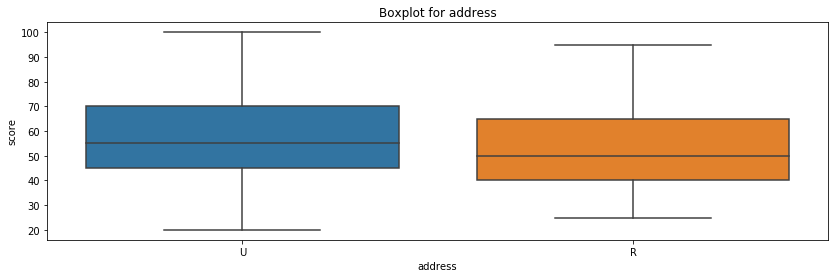

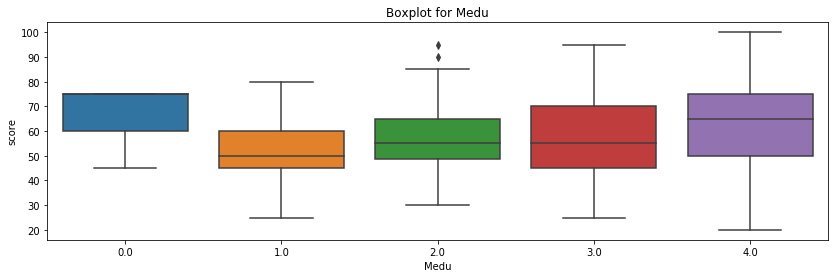

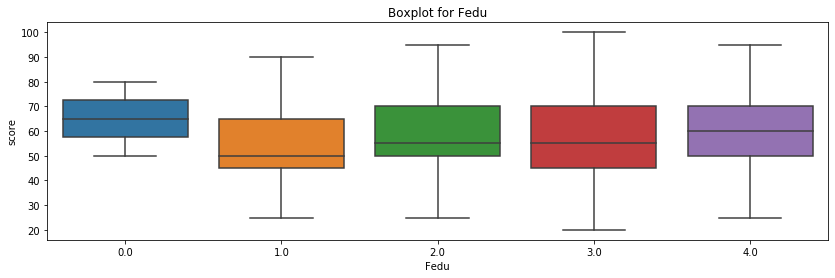

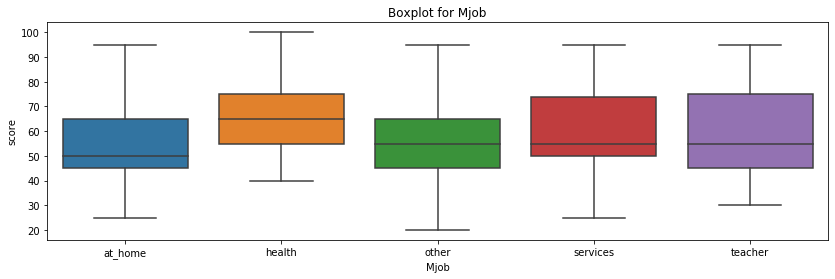

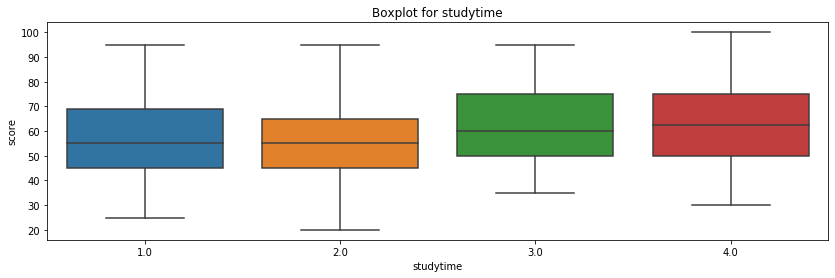

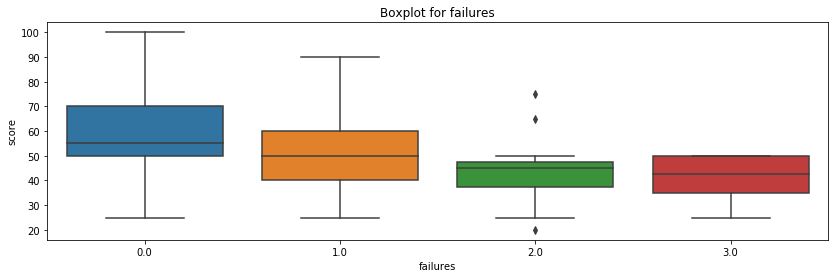

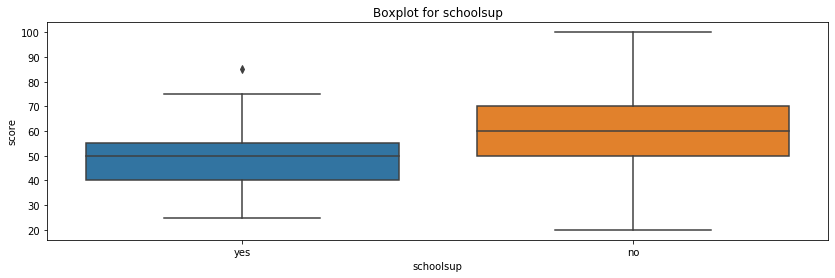

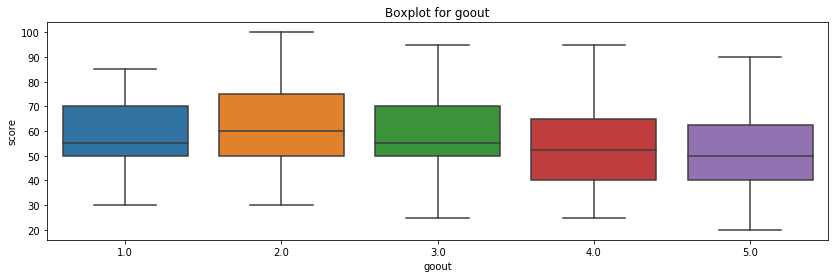

In [15]:
# колонки с категориями (без 'numerical')
cat_par = [x for x in name_columns if dc[x][0] != 'numerical']

print('Статистически значимые переменные:')
res_stud = list()
for col in cat_par:
    if get_stat_dif(col):
        res_stud.append(col)

# графики для этих переменных
for col in res_stud:
    get_boxplot(col)

    Статистически значимые переменные по уровню значимости 0.05:
    address, Medu, Fedu, Mjob, studytime, failures, schoolsup, goout
### 6) Рассмотрим влияние параметров на получение "0" по экзамену
#### 6.1 Влияние 'absences' на результат "0" очков по экзамену

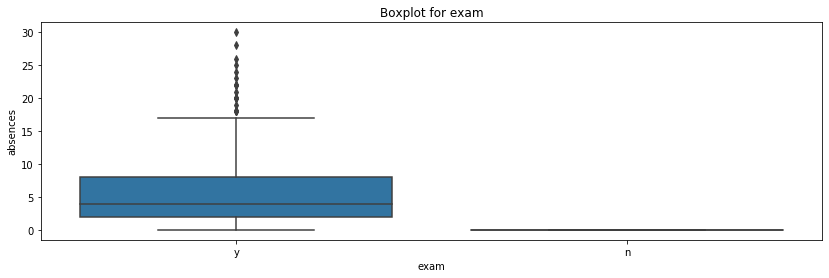

In [16]:
# stud2 датасет с 0 в 'score', но без None в 'absenses'
stud2 = stud.drop(stud.index[stud['absences'].isna()], inplace=False)
stud2['exam'] = stud2.score.apply(lambda x: 'y' if x > 0 else 'n')
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='exam', y='absences', data=stud2, ax=ax)
ax.set_title('Boxplot for exam')
plt.show()

На графике видно, что у кого 0 по экзамену, пропущенных занятий тоже 0 (всегда),
можно предположить - ученикам не отмечали пропуски, потому, что они вообще
не учились и соответственно не было экзамена.

#### 6.2 Проверка влияния номинативных параметров на получение оценки "0"
Нулевая гипотеза - параметры не влияют и распределение на каждом из них 
между "есть оценка" и "нет оценки (0)" одинаково

In [17]:
# вводим параметр есть оценка - 'y' или нет оценки - 'n'
stud['exam'] = stud.score.apply(lambda x: 'y' if x > 0 else 'n')

# функция для анализа


def stat_prop(column, alpha=0.05):
    """
        Проверка гипотезы по параметру "column", уровень значимости alpha. 
        Гипотеза H0 - по каждому значению параметра пропорция между 'y' и 'n' 
        одинакова. Расчитываем отношение для каждого значения параметра по количеству
        оценок 'y' - есть(какя-то) и 'n' - нет(0), тестируем по z-распределению.
    """
    res_col = dict()
    str_par = 'n'  # 'y' or 'n' # какую пропорцию считаем (результат один)
    # комбинаций с None нет
    combinations_all = list(combinations(dc[column], 2))
    for comb in combinations_all:

        # подсчёт числа 'y' и 'n' по заданной комбинации параметров
        par1 = stud.loc[stud.loc[:, column] == comb[0], 'exam'].value_counts()
        par2 = stud.loc[stud.loc[:, column] == comb[1], 'exam'].value_counts()

        if str_par not in par1:
            par1[str_par] = 0
        if str_par not in par2:
            par2[str_par] = 0

        n1 = par1.sum()
        n2 = par2.sum()
        if (n1 == 0) | (n2 == 0):
            continue

        p1 = par1[str_par] / n1
        p2 = par2[str_par] / n2

        # проверка достаточной величины выборки
        if (n1*p1 > 5) & (n1*(1-p1) > 5) & (n2*p2 > 5) & (n2*(1-p2) > 5):
            p_ = (p1*n1 + p2*n2) / (n1 + n2)
            s_ = (p_*(1 - p_) * (1/n1 + 1/n2))**0.5
            z_st = np.abs((p1 - p2) / s_)
            p_val = 1 - norm.cdf(z_st)
            if p_val < alpha/2:
                res_col[comb] = p_val
    return res_col


# анализ - результаты в словарь
res_stud_exam = dict()
for col in cat_par:
    d_col = stat_prop(col)
    if len(d_col) > 0:
        res_stud_exam[col] = d_col

print('Переменные влияющие на получение оценки:')
print(list(res_stud_exam.keys()))

Переменные влияющие на получение оценки:
['Medu', 'failures', 'paid', 'higher', 'romantic', 'goout']


Как видно, на пропорцию "есть оценка" и "0" влияют переменные 'Medu', 'failures', 'paid', 'higher', 'romantic', 'goout'


### 7) Выводы.
    
Корреляция 'score' (без 0) с:

'age':         -0.12

'absences':    -0.23

Влияющие на 'score' переменные:
'address', 'Medu', 'Fedu', 'Mjob', 'studytime', 'failures', 'schoolsup', 'goout'.

Переменные влияющие на получение оценки ">0" или "0":
'Medu', 'failures', 'paid', 'higher', 'romantic', 'goout'.

Статистическая проверка проводилась с уровнем значимости 0.05.

Не указанные выше переменные (условия жизни учащихся) определены как не влияющие на успеваемость и для построения модели не используются.
